In [68]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import json
import os

In [208]:
root_path = os.path.join(os.environ['HOME'], 'projects/tuplex-public/tuplex/cmake-build-debug/dist/bin')
path = root_path + '/aws_job.json'

In [209]:
# !cp /Users/leonhards/projects/tuplex-public/tuplex/cmake-build-debug/dist/bin/aws_job.json{,.backup}

In [210]:
os.path.isfile(path)

True

In [211]:
with open(path, 'r') as fp:
    data = json.load(fp)

In [212]:
data

{'stageStartTimestamp': 1643353650763867000,
 'stageEndTimestamp': 1643353710963200000,
 'tasks': [{'container': {'reused': False,
    'requestId': '78dc392d-b7bb-4172-9f09-473d53475804',
    'uuid': '15fdd4d5-bcbd-4a0b-8805-cfa2f76e4317',
    'msRemaining': 545211,
    'requestsServed': 1,
    'startTimestamp': 1643353654954160831,
    'deadlineTimestamp': 1643354254991000000},
   'invoked_containers': [{'reused': False,
     'requestId': '8dc23c11-163c-4e99-87ac-a5cd29904a3a',
     'uuid': '64dcebc1-e18d-4c42-ad28-44101358d739',
     'msRemaining': 597456,
     'requestsServed': 1,
     'startTimestamp': 1643353657954857945,
     'deadlineTimestamp': 1643354257990000000},
    {'reused': False,
     'requestId': '452e4302-9609-4e47-9202-55192ae4d1e6',
     'uuid': 'c1c14ed6-8e8e-46e0-8ef5-372ad388cd7d',
     'msRemaining': 597992,
     'requestsServed': 1,
     'startTimestamp': 1643353657835947567,
     'deadlineTimestamp': 1643354257874000000},
    {'reused': False,
     'requestId'

In [213]:
# analyze invocations with start/end
# -> want to add request start & request end in absolute times!
# --> these values should be filled in by the caller!

In [214]:
rows = []

global_start = data['stageStartTimestamp'] / 1e9

job_duration = data['stageEndTimestamp'] / 1e9 - global_start

def row_from_container(task):
    start_ts = task['startTimestamp'] / 1e9
    dead_ts = task['deadlineTimestamp'] / 1e9
    remaining_s = task['msRemaining'] / 1000.0
    end_ts = dead_ts - remaining_s
    
    duration = end_ts - start_ts
    t = dead_ts - start_ts
    
    row = {'start' : start_ts - global_start,
           'end' : end_ts - global_start,
           'duration' : duration,
           'uuid' : task['uuid']}
    return row


# add the first invoking container!
row = row_from_container(data['tasks'][0]['container'])
# row['start'] += global_start
# row['end'] += global_start
rows.append(row)
for c in data['tasks'][0]['invoked_containers']:
    row = row_from_container(c)
    rows.append(row)

In [215]:
job_duration

60.19933319091797

In [216]:
rows[0]

{'start': 4.190294027328491,
 'end': 59.016133308410645,
 'duration': 54.82583928108215,
 'uuid': '15fdd4d5-bcbd-4a0b-8805-cfa2f76e4317'}

In [217]:
df = pd.DataFrame(rows)#.reset_index().rename(columns={'index' : 'request'})

In [218]:
# group after uuid and get from there number (asc after start!)
df = df.sort_values(by=['end'])

In [219]:
len(df['uuid'].unique())

338

In [220]:
df.sort_values(by=['start']).head()

,start,end,duration,uuid
0,4.190294,59.016133,54.825839,15fdd4d5-bcbd-4a0b-8805-cfa2f76e4317
174,5.007704,7.612133,2.604429,94660e58-d6d8-47f3-afa7-d52a9f6127da
148,5.070320,6.892133,1.821813,137b9f93-f5f1-49b3-94ad-445876ab79db
175,5.125992,7.213133,2.087141,2155ce41-f138-42f1-addd-7d3ad1f3e099
187,5.222759,7.069133,1.846373,80ecac8d-1c7c-4d89-8ae9-8fe8b2789adb


In [221]:
# this is information regarding containers
# => want to know something about requests though!

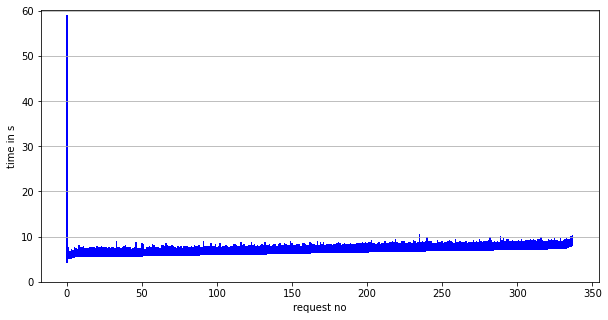

In [222]:
plt.figure(figsize=(10, 5))


pos = 0
for idx, row in df.sort_values(by=['start']).iterrows():
    plt.bar(pos, row['duration'], 1, bottom=row['start'], color='blue')
    pos += 1
# plt.xticks([0, 1, 2, 3])
plt.ylim(0, job_duration)
# plt.x
plt.ylabel('time in s')
plt.xlabel('request no')
plt.grid(axis='y')

In [82]:
data['tasks'][0]['invoked_containers']

[{'reused': False,
  'requestId': 'b8905283-be18-4727-b914-9b4c23f30b61',
  'uuid': '8397ce4a-0279-4350-a008-eb818eb1f464',
  'msRemaining': 597987,
  'requestsServed': 1,
  'startTimestamp': 1643349680809836438,
  'deadlineTimestamp': 1643350280846000000},
 {'reused': False,
  'requestId': 'a06206e9-469e-413c-9187-9fb4d061fb3f',
  'uuid': '44629c20-e17c-4032-882e-b6e98286ffc4',
  'msRemaining': 597879,
  'requestsServed': 1,
  'startTimestamp': 1643349680961759223,
  'deadlineTimestamp': 1643350280998000000},
 {'reused': False,
  'requestId': '3104dc70-3cc0-4c7d-9f96-e05102b8b473',
  'uuid': '76a84344-931f-44c7-87da-20c7040748d3',
  'msRemaining': 598131,
  'requestsServed': 1,
  'startTimestamp': 1643349680923476145,
  'deadlineTimestamp': 1643350280959000000}]

In [27]:
import datetime

In [ ]:
stageStart

In [28]:
datetime.datetime.fromtimestamp(1643339402105915345)

OSError: [Errno 22] Invalid argument

In [30]:
help(datetime.datetime.fromtimestamp)

Help on built-in function fromtimestamp:

fromtimestamp(...) method of builtins.type instance
    timestamp[, tz] -> tz's local time from POSIX timestamp.



In [37]:
import time
datetime.datetime.fromtimestamp(time.time())

datetime.datetime(2022, 1, 27, 23, 50, 57, 880027)

In [47]:
datetime.datetime.fromtimestamp(1643339404174495380 / 1e9)

datetime.datetime(2022, 1, 27, 22, 10, 4, 174495)

In [49]:
datetime.datetime.fromtimestamp(391858287253828 / 1e9)

datetime.datetime(1970, 1, 5, 7, 50, 58, 287254)